# March Madness and Analytics:

## Can you Predict NCAA Basketball Tournament Bids from the Massey Ratings?

In another notebook, we looked at the correlation between tournament bids for men's and women's NCAA D-1 basketball teams.  We used data for rankings that were based on the [Massey Ratings](https://www.masseyratings.com).  In this notebook we try to understand the relationship between the Massey Rating and the likelihood that a team get a tournament bid.

This process is very similar to any analytics project in  which you are trying to predict a binary outcome from a numeric variable (frequently a continuous variable). We postpone that for another notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from numpy import random
# Set the seed if you want to get the same results from run to run.
# random.seed(2021)

I downloaded Massey Ratings to the csv files `Massey_men_d1.csv` and `Massey_women_d1.csv` 
from [here](https://www.masseyratings.com/cb/ncaa-d1/ratings) for the men and
from [here](https://www.masseyratings.com/cbw/ncaa-d1/ratings) for the women. The *rating* is a continuous 
numerical variable, and it is accompanied by a *ranking* according to those values. You can read on the Massey Ratings site how they derive the ratings. In the other notebook, on Kendall's Tau, we primarily analyzed ranking. In this notebook we focus on the rating, but this entire analysis could be done using ranking as the numeric variable.

We could do the following analysis for both men's and women's teams in one notebook, we could do each gender in separate notebooks, or we could flip a coin and do the analysis for a single gender.  We choose to flip a coin (of course).

In [3]:
coin_flip = "heads" if random.rand()<0.5 else "tails"

if coin_flip == "heads":
    gender = "men"
else:
    gender = "women"

print(f' Coin flip is {coin_flip}: {gender.title()}')

 Coin flip is heads: Men


In [4]:
usecols = ['Team','Rat','Unnamed: 6']
colmapping={'Rat':'Ranking','Unnamed: 6':'Massey_rating'}
df_ratings = pd.read_csv(f'Massey_{gender}_d1.csv',
                         usecols=usecols,
                         index_col='Team').rename(columns=colmapping)
df_ratings['Gender'] = gender.title()  

In [5]:
df_ncaa_field = pd.read_csv(f'tournament_{gender}.csv')
df_ncaa_field['Tournament_bid'] = True

In [6]:
df_ratings = df_ratings.merge(df_ncaa_field,on='Team',how='outer').fillna(False)

In [7]:
df_ratings = df_ratings[['Team', 'Gender', 'Massey_rating', 'Ranking', 'Tournament_bid']]

In [8]:
df_ratings.sample(5).sort_values('Massey_rating')

,Team,Gender,Massey_rating,Ranking,Tournament_bid
340,Howard,Men,4.46,341,False
106,Belmont,Men,6.98,106,False
65,St John's,Men,7.56,66,False
25,Virginia,Men,8.13,26,True
26,San Diego St,Men,8.13,27,True


## How do the ratings compare between the teams with and without tournament bids?

We start by just looking at some descriptive statistics using the `groupby` and `describe` methods.

In [9]:
df_ratings.groupby('Tournament_bid').Massey_rating.describe()

,count,mean,std,min,25%,50%,75%,max
Tournament_bid,,,,,,,,
False,279.0,6.062294,0.911219,3.14,5.41,5.99,6.725,8.05
True,68.0,7.760147,0.838681,5.67,7.29,8.01,8.240,9.86


We see that mean ratings between the teams getting tournament bids and those who did not are fairly well separated. Certainly, we can conduct a t-test for independent samples.  Here we see that Student's t statistic is large with a corresponding p-value that is extremely small. 

See the documentation at [scipy.stats.ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for details.  I have set the keyword argument `equal_var` to `True`. This is the default, but it's good to be aware that it need not be assumed.

In [10]:
from scipy.stats import ttest_ind

In [11]:
teams_grouped = df_ratings.groupby('Tournament_bid')

a = np.array(teams_grouped.get_group(True).Massey_rating)
b = np.array(teams_grouped.get_group(False).Massey_rating)

ttest_ind(a,b,axis=0,equal_var=True)

Ttest_indResult(statistic=13.986641487732363, pvalue=1.5860805062574027e-35)

### Plotting the Ratings by Group

Here we plot histograms of the subgroups.

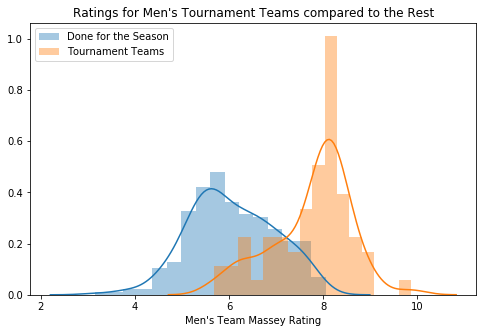

In [12]:
plt.figure(figsize=(8,5))
teams_grouped.apply(lambda x: sns.distplot(x.Massey_rating,kde=True,bins=16));
plt.legend(['Done for the Season','Tournament Teams']);
plt.xlabel(f"{gender.title()}'s Team Massey Rating")
plt.title(f"Ratings for {gender.title()}'s Tournament Teams compared to the Rest");

## How can we use Massey Ratings to assess the likelihood of making the tournament?

A team's rating *should* tell us how likely they are to make the tournament. But as we see above, there is significant overlap between the teams that make it into the tournament and those that don't.  Obviously, teams that don't win their conference's automatic bid, need to be ranked high enough to get into the tournament. Teams that fall in that overlapping zone are frequently referred to as being "on the bubble".

If we were going to predict which teams made the tournament from the rating alone, we would try to choose some middle value, predicting that any team above that threshold is likely to get a bid, and teams below the threshold are likely to not get a bid.  How should we choose that threshold?

### Using ROC Curves

We treat the rating as an independent variable and use it to set a threshold value for the rating as a proxy for getting into the tournament. A team with a rating above the threshold is a "positive" test case. If the team also made the tournament, it is a *true positive*. Otherwise it is a *false positive* (sometimes called a *false alarm* for historical reasons). 

For example consider a rating of 8.2 for the men (7.7 for the women). That's close to the 75th percentile for the men's tournament field and higher than 8.05 which is the maximum rating for the non-tournament teams. So we have a true positive rate of about 25% (or 0.25). Since there are non-tournament teams above the threshold, there are no false positives, i.e. the false positive rate is 0%. Visually, the true positive rate (TPR) is the area under the orange curve to the right of the threshold value, and the false positive rate (FPR) is the area under the blue curve to the right of the threshold value. Consider the threshold of 7.0. Now we have over 75% of the tournament field above 7, and slightly less than 25% of the non-tournament teams are above 7 (false positives). For a threshold as low as 6.0, we are capturing nearly 100% of tournament teams but only 50% of non-tournament teams.

**The ROC Curve plots the true positive rate against the false positive rate.**  As the threshold rating falls from the maximum of 9.86 to the minimum of 3.14 for the men, the TPR and FPR both rise from 0 to 1. So the ROC Curve increases monotonically from (0,0) to (1,1).

**Note:** *If there were no difference between the two distributions, then the true positive rate and the false positive rate would be roughly same for every value of the rating, and the ROC curve would coincide with the diagonal line joining (0,0) to (1,1).*

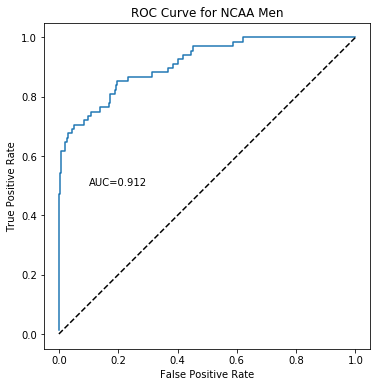

In [13]:
# ranks are just the sequence from 1 to 348
df_ratings.sort_values('Massey_rating',ascending=False,inplace=True)
ratings = np.array(df_ratings.Massey_rating)

# Define the true/false positives and true/false positive rates. 
tp = np.array(df_ratings.Tournament_bid.cumsum())
fp = np.array((1 - df_ratings.Tournament_bid).cumsum())
tpr = tp/df_ratings.Tournament_bid.sum()
fpr = fp/(1 - df_ratings.Tournament_bid).sum()

# Now we plot the TPR against the FPR to get the ROC curve.
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);

# Add the diagonal line and ...
plt.plot(fpr,fpr,'--k');

# We compute the AUC we use "midpoint rule"
# However, the ROC curve consists of horizontal and vertical 
# line segments; so we could have used either right or left endpoints.
y = (tpr[:-1] + tpr[1:])/2
delta_x = np.diff(fpr)
auc = (y*delta_x).sum()
plt.text(.1, .5,f'AUC={auc:.3f}')

# Add labels and title.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for NCAA {gender.title()}')
plt.axis('square');

What is the best threshold to set? Or at least a good threshold...

The Youden Index is the point at which the ROC curve is the highest above the diagonal. If the ROC curve is smooth, it is also the point where the True Positive Rate equals the False Positive Rate. I.e. the slope of the tangent line is parallel to the diagonal. So this is the point at which changing the threshold by a small amount admits equal numbers of true and false positives.  This may be a good choice for setting a threshold for using the ranking for predicting who makes the tournament.

We can compute the value of the Youden Index and find the corresponding values of the Massey rating as well as the corresponding TPR and FPR.

Why might one choose a different threshold? One needs to assess the *recall* and *precision* values and consider your objectives. Is recall more important than precision? Or vice versa?  The [F-score](https://en.wikipedia.org/wiki/F-score) attempts to balance recall and precision. It is the harmonic mean of the two metrics. The F-beta score is a weighted harmonic mean which allows one to put more or less weight on recall relative to precision.

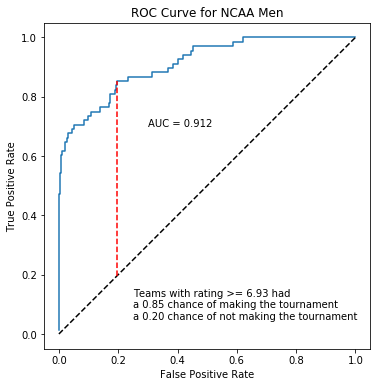

In [14]:
# ranks are just the sequence from 1 to 348
df_ratings.sort_values('Massey_rating',ascending=False,inplace=True)
ratings = np.array(df_ratings.Massey_rating)

# Define the true/false positives and true/false positive rates. 
tp = np.array(df_ratings.Tournament_bid.cumsum())
fp = np.array((1 - df_ratings.Tournament_bid).cumsum())
tpr = tp/df_ratings.Tournament_bid.sum()
fpr = fp/(1 - df_ratings.Tournament_bid).sum()

# The Youden index is the point where the ROC curve is highest above
# the diagonal.
youden = tpr - fpr
youden_idx = list(youden).index(youden.max())
tpr_youden = tpr[youden_idx]
fpr_youden = fpr[youden_idx]
rating_youden = ratings[youden_idx]

# Now we plot the TPR against the FPR to get the ROC curve.
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr);

# Add the diagonal line and ...
plt.plot(fpr,fpr,'--k');

# drop a vertical from the ROC curve at the Youden index.
plt.plot([fpr_youden,fpr_youden],[fpr_youden,tpr_youden],'--r');

# We compute the AUC we use "midpoint rule"
# However, the ROC curve consists of horizontal and vertical 
# line segments; so we could have used either right or left endpoints.
y = (tpr[:-1] + tpr[1:])/2
delta_x = np.diff(fpr)
auc = (y*delta_x).sum()

# Annotate the plot with the AUC and some info about the Youden index.
plt.text(.3, .7,f'AUC = {auc:.3f}')
plt.text(0.25,0.05, f'Teams with rating >= {rating_youden:.2f} had\n' +\
         f'a {tpr_youden:.2f} chance of making the tournament\n' + \
         f'a {fpr_youden:.2f} chance of not making the tournament')

# Add labels and title.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for NCAA {gender.title()}')
plt.axis('square');

Let's consider other metrics: recall, precision, and accuracy.

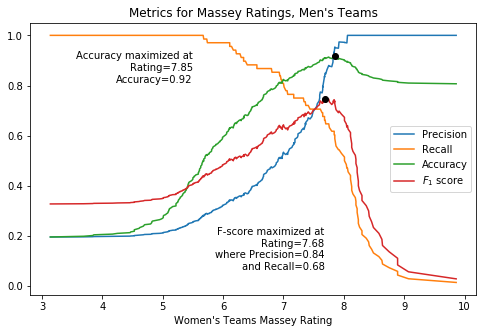

In [15]:
# Compute the false/true negatives.
fn = df_ratings.Tournament_bid.sum()- tp
tn = (1 - df_ratings.Tournament_bid).sum() - fp

# We use the previously and newly computed values to compute 
# additional metrics:
precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tp + tn)/(tp + fp + tn + fn)
f_score = 2/((1/(precision + 1e-6)) + (1/(recall + 1e-6)))

# Find the place where the F-score and accuracy are maximized.
f_idx = list(f_score).index(f_score.max())
a_idx = list(accuracy).index(accuracy.max())

# Plot metrics.
plt.figure(figsize=(8,5))
plt.plot(ratings,precision,label='Precision')
plt.plot(ratings,recall,label='Recall')
plt.plot(ratings,accuracy,label='Accuracy')
plt.plot(ratings,f_score,label='$F_1$ score')

# Mark the maximum F-score, accuracy
plt.plot(ratings[f_idx],f_score[f_idx],'ok')
plt.plot(ratings[a_idx],accuracy[a_idx],'ok')

# Annotate the plots
plt.text(ratings[f_idx],0.02,f'F-score maximized at\nRating={ratings[f_idx]:.2f}\n' +
        f'where Precision={precision[f_idx]:.2f}\n' +
        f'and Recall={recall[f_idx]:.2f}\n',
        ha='right')
plt.text(5.5, -0.15 + accuracy[a_idx],f'Accuracy maximized at\nRating={ratings[a_idx]:.2f}\n' +
        f'Accuracy={accuracy[a_idx]:.2f}\n',
        ha='right')


# Label the plot.
plt.legend(loc=5);
plt.xlabel("Women's Teams Massey Rating");
plt.title(f"Metrics for Massey Ratings, {gender.title()}'s Teams");

We note that the Youden Index may not be the same as the point that maximizes the F-score.  For example, for the men, the rating that maximizes the F-score (7.68) is slightly higher than the Youden Index (7.59), and the rating that maximizes accuracy (7.85) is higher yet.  For the women the three indexes are the same.

## A Machine Learning Approach

Can we use this data to create a *predictive* model? In particular, can we predict which teams will make the NCAA tournament? Yes we can! 

But we need to think through what data we could use and how and whether a model could generalize.  For example, we might ask whether we want to use the Massey rating or just the ranking? How consistent are Massey ratings from year to year? If we use the rankings based on the Massey ratings, does this generalize to rankings based on say the Sagarin ratings in USA Today or some other source? We might also consider how a team's conference and their rank within the conference affect the prospects of getting a bid.

Let's take a quick look at what a model might look like.  Here is a simple decision tree. You could try changing the parameters for the tree. We find that there is not much gain by increasing the max_depth, but you should see for yeourself. You can also change the feature set. In this data we only have ranking and rating, but as noted above we could generate more features.

Note that we are splitting the data into training and test subsets.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [17]:
# Set the feature set and target set. 
# Note the target can be list of length more than 1, though it would make 
# no sense for this dataset!

# feature_list = ['Ranking']
feature_list = ['Massey_rating']
# feature_list = ['Massey_rating','Ranking']
target_list = ['Tournament_bid']

X = np.array(df_ratings[feature_list]).reshape(-1,len(feature_list))
y = np.array(df_ratings[target_list]).reshape(-1,len(target_list))

# Set the random_state if you want consistent results for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     random_state=0
                                                   )

clf = DecisionTreeClassifier(random_state=42,
                             max_depth=1,
                             min_samples_leaf=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

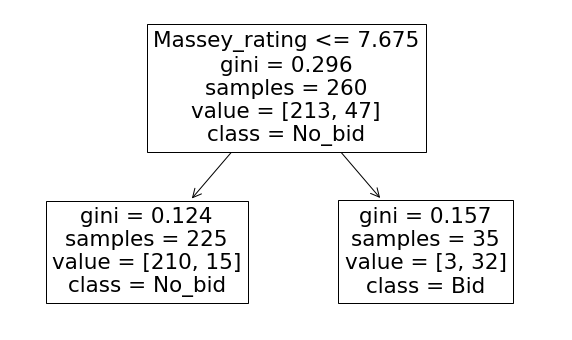

In [18]:
plt.figure(figsize=(10,6))
tree.plot_tree(clf,
               feature_names=feature_list,
               class_names=['No_bid','Bid'])
plt.show()

Note that the cut point for the first node in the tree is approximately equal to the cut point we determined from the ROC curve analysis even though it was trained on 75% sample of the whole data set. How does this tree perform on the test set?

In [19]:
clf.score(X_test,y_test)

0.8505747126436781

Let's take a random sample of the original data frame and apply the model.

In [20]:
df_sample = df_ratings.sample(25)

X_sample = np.array(df_sample[feature_list]).reshape(-1,len(feature_list))
df_sample['Model_prediction'] = clf.predict(X_sample)

df_sample[['Team','Gender','Massey_rating',
           'Model_prediction','Tournament_bid']].sort_values('Massey_rating',ascending=False)

,Team,Gender,Massey_rating,Model_prediction,Tournament_bid
16,UCLA,Men,8.24,True,True
20,Creighton,Men,8.22,True,True
29,West Virginia,Men,8.11,True,True
61,Wichita St,Men,7.61,False,True
71,St Louis,Men,7.44,False,False
83,Dayton,Men,7.24,False,False
84,Georgia,Men,7.24,False,False
100,Nebraska,Men,7.04,False,False
118,Indiana St,Men,6.88,False,False
158,New Mexico St,Men,6.43,False,False
